In [1]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
import pandas as pd

In [4]:
parser = Sbopen()
df_match = parser.match(competition_id=43, season_id=106)
team = "Netherlands"

match_ids = df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)]["match_id"].tolist()
no_games = len(match_ids)

In [5]:
match_ids

[3869321, 3857294, 3869117, 3857285, 3857274]

In [6]:
danger_passes = pd.DataFrame()
for idx in match_ids:
    df = parser.event(idx)[0]
    for period in [1, 2]:
        mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull()) 
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]
        mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
        shots = df.loc[mask_shot, ["minute", "second"]]
        shot_times = shots['minute']*60+shots['second']
        shot_window = 15  
        shot_start = shot_times - shot_window
        shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
        pass_times = passes['minute']*60+passes['second']
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())
        danger_passes_period = passes.loc[pass_to_shot]
        danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)

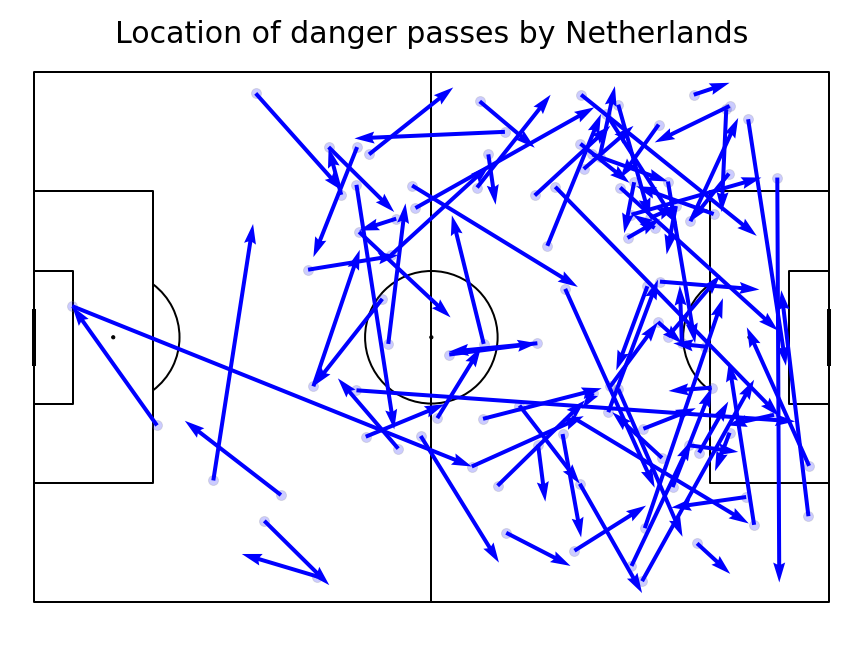

In [8]:
#danger pass initial point scattering

pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])
pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = "blue", ax=ax['pitch'])

fig.suptitle('Location of danger passes by ' + team, fontsize = 30)
plt.show()

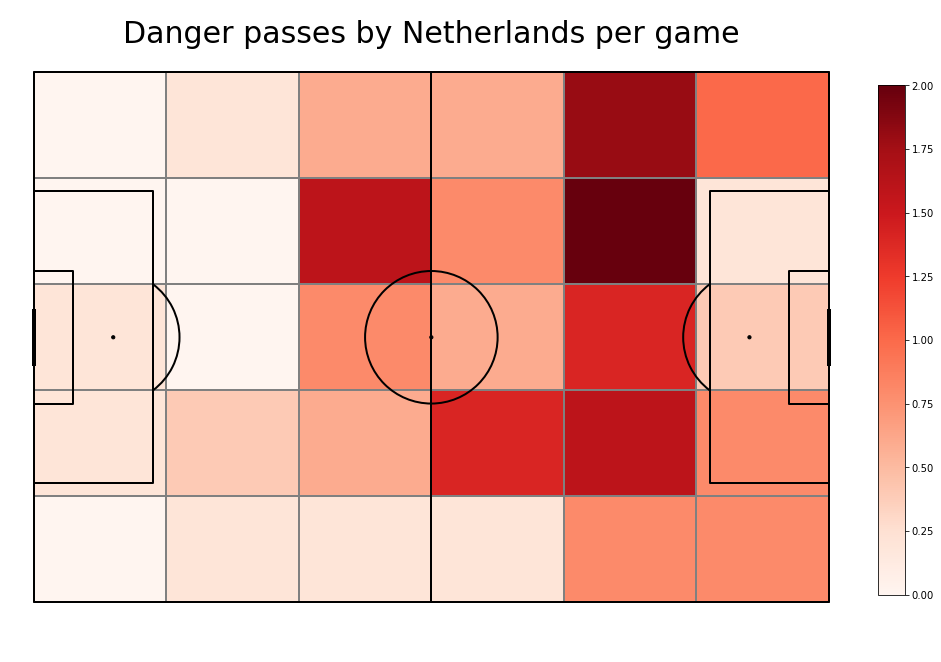

In [9]:
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(6, 5), normalize=False)
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games

pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by ' + team + " per game", fontsize = 30)
plt.show()